In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('fivethirtyeight')
%matplotlib inline

# House Price Prediction

## Contents

* Part1: Exploratory Data Analysis(EDA)

* Part2: Feature Engineering and Data Cleaning

* Part3: Create New Variable

* Part4: Predictive Modeling

----------------

##  Part1: Exploratory Data Analysis(EDA)

train, test 데이터프레임을 생성합니다.

In [70]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration6/house_price_prediction'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [71]:
train.head(20)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,20140527T000000,468000.0,2,1.00,1160,6000,1.0,0,0,4,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,20140528T000000,310000.0,3,1.00,1430,19901,1.5,0,0,4,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,8,20141007T000000,400000.0,3,1.75,1370,9680,1.0,0,0,4,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,9,20150312T000000,530000.0,5,2.00,1810,4850,1.5,0,0,3,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


변수 설명

* ID : 집을 구분하는 번호   
*date : 집을 구매한 날짜   
*price : 집의 가격(Target variable)   
*bedrooms : 침실의 수   
*bathrooms : 화장실의 수   
*sqft_living : 주거 공간의 평방 피트(면적)   
*sqft_lot : 부지의 평방 피트(면적)   
*floors : 집의 층 수   
*waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)   
*view : Has been viewed   
*condition : 집의 전반적인 상태   
*grade : King County grading 시스템 기준으로 매긴 집의 등급   
*sqft_above : 지하실을 제외한 평방 피트(면적)   
*sqft_basement : 지하실의 평방 피트(면적)   
*yr_built : 지어진 년도   
*yr_renovated : 집을 재건축한 년도   
*zipcode : 우편번호   
*lat : 위도   
*long : 경도   
*sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)   
*sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

결측치 확인

In [72]:
print(train.shape)
print(train.nunique())

(15035, 21)
id               15035
date               365
price             3263
bedrooms            11
bathrooms           29
sqft_living        863
sqft_lot          7678
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         789
sqft_basement      271
yr_built           116
yr_renovated        65
zipcode             70
lat               4692
long               716
sqft_living15      682
sqft_lot15        6958
dtype: int64


In [73]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

date 칼럼은 15개의 숫자로 이루어져 있습니다. 이 중에서 의미를 부여할 수 있는 년,월까지만 추출합니다.

In [74]:
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [75]:
train['date'] = train['date'].apply(lambda i : i[:6]).astype(int)

In [76]:
test['date'] = test['date'].apply(lambda i : i[:6]).astype(int)

각 feature의 분포를 확인해 보겠습니다.

In [77]:
len(train.columns)

21

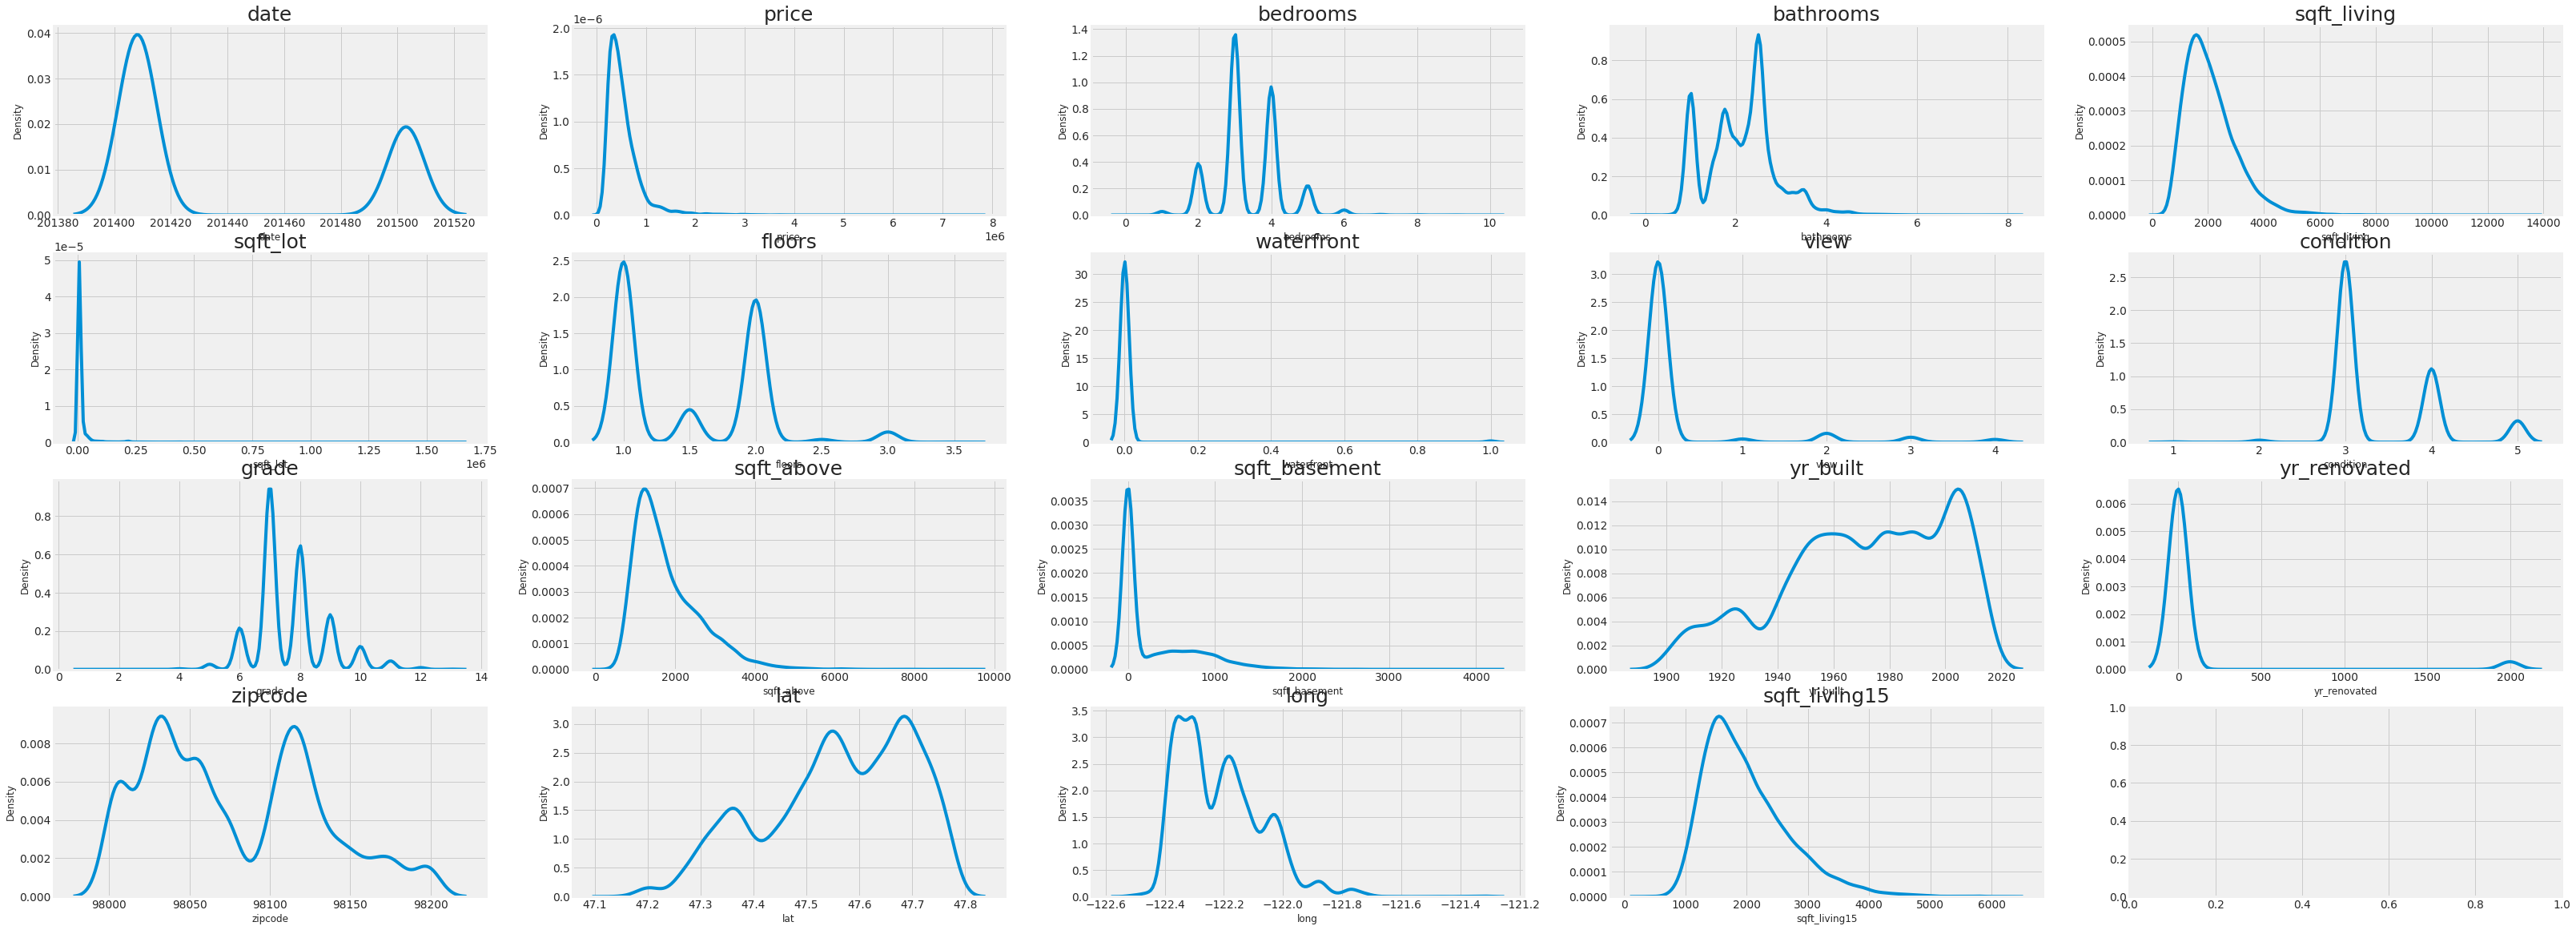

In [78]:
fig, ax = plt.subplots(4, 5, figsize=(50, 20))

count = 1
columns = train.columns

for row in range(4):
  for col in range(5):
    sns.kdeplot(train[columns[count]], ax = ax[row][col])
    ax[row][col].set_title(columns[count], fontsize=25)
    count += 1
    if count ==20:
      break

'price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15', 'sqft_lot15' 는 연속형 데이터이며 치우침이 심해 정규화가 필요한듯 합니다.   
하지만 이상치 검출 등의 과정을 거쳐야 하니 정규화는 나중에 시행하도록 하겠습니다.

In [79]:
b_list = ['basrooms', 'view', 'condition', 'grade']

어떤 변수들간 상관관계가 있는지 대략적으로 파악하는 것이 좋습니다.  
히트맵을 통해 상위 10개 정도의 값을 살펴보겠습니다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


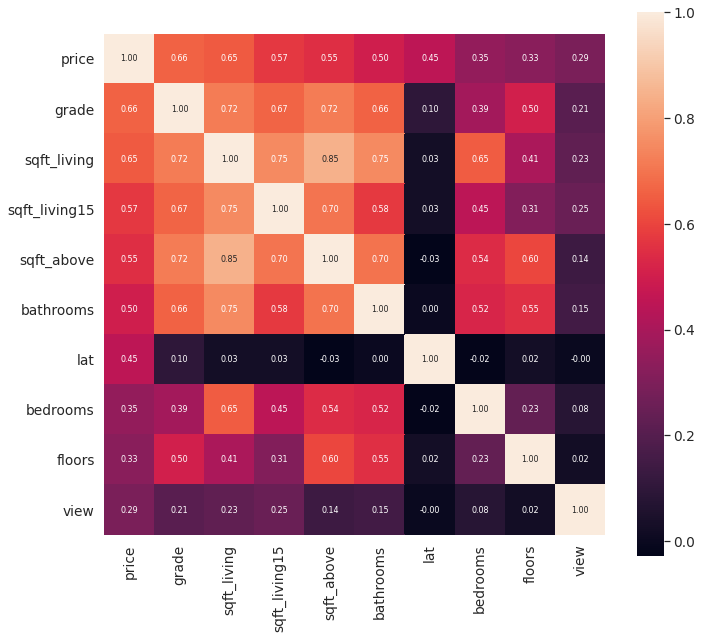

In [80]:
# 출처: https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12

import scipy as sp

cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)

# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10x10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size' : 8}, xticklabels=cor_cols.values, yticklabels=cor_cols.values)

히트맵 상에서 가격과 높은 상관도를 보이는 피처는 grade, sqrt_living, sqrt_linig15, sqrt_bove, bathrooms입니다. 이들을 차례로 살펴 보겠습니다.

> 1.1 grade

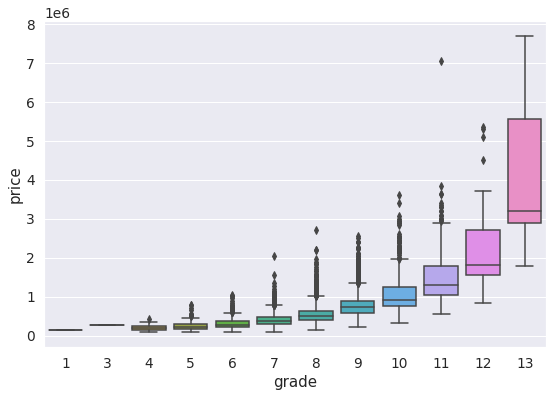

In [81]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fit = sns.boxplot(x='grade', y = 'price', data=data)

grade가 높아질 수록 확실히 가격은 올라갑니다. 하지만 3의 경우 4보다 높은 가격대를 형성하고 있습니다. 그 이유는 강남과 같이 부유한 곳에 위치하는 등이 있을 것입니다.이외에도 7 - 12 grade에서 이상치가 많은 이유를 살펴봐야 할 것입니다.

-----------------------

> 1.2 sqft_living  
sqft_living과 sqft_living15는 주거 공간의 면적을 의미합니다. 15의 경우 2015년 기준이기 때문에 처음 집을 지은 이후 재건축 여부에 따라 수치가 달라질 수 있습니다.

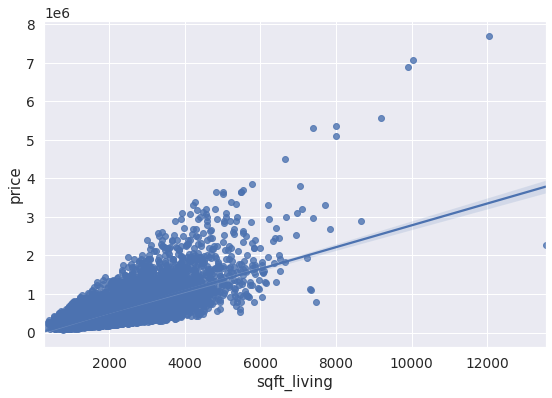

In [82]:
data = pd.concat([train['sqft_living'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

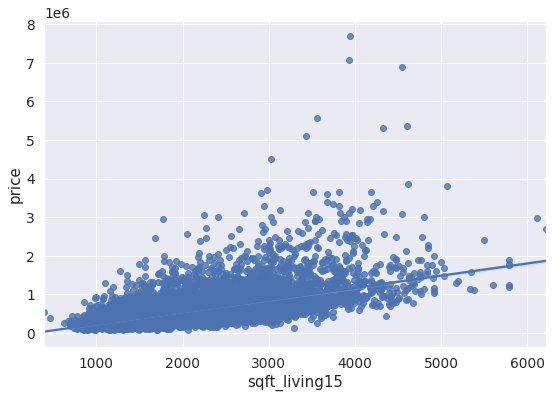

In [83]:
data = pd.concat([train['sqft_living15'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_living15', y='price', data=data)

sqft_living15의 경우 분산이 더욱 커진 것을 발견할 수 있습니다. 이로써 재건축을 통해 집들의 면적이 전반적으로 늘어났다는 것을 추측할 수 있습니다.

sqft_above는 지하실을 제외한 면적을 의미합니다. 이외에도 지하실의 면적(sqft_basement), 부지의 면적(sqft_lot)의 분포를 탐색하는 것이 좋을 것 같습니다.

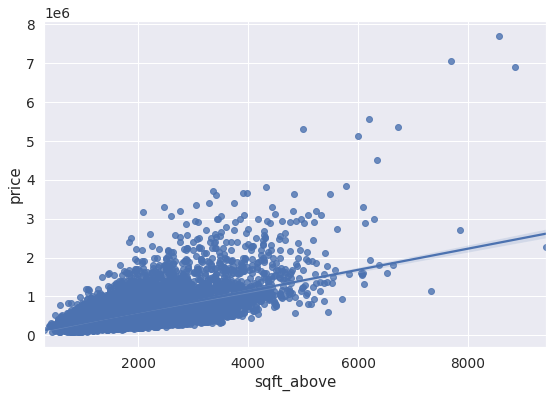

In [84]:
data = pd.concat([train['sqft_above'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_above', y='price', data=data)

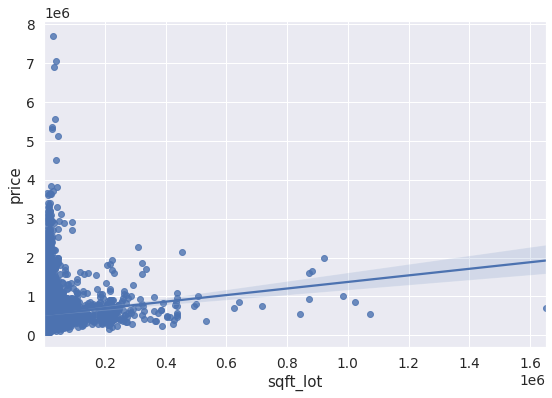

In [85]:
data = pd.concat([train['sqft_lot'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_lot', y='price', data=data)

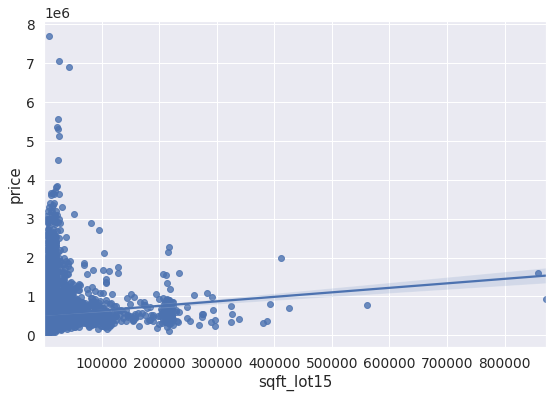

In [86]:
data = pd.concat([train['sqft_lot15'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_lot15', y='price', data=data)

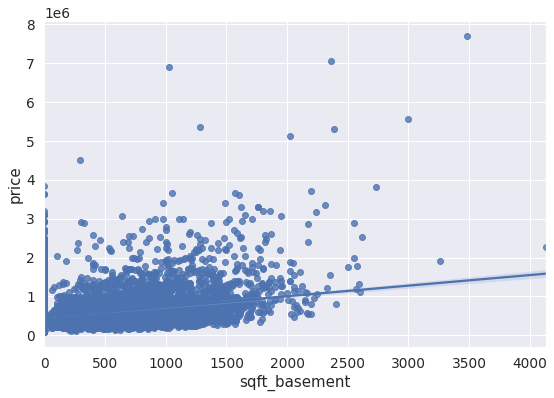

In [87]:
data = pd.concat([train['sqft_basement'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_basement', y='price', data=data)

부지의 면적(sqft_lot), (sqft_lot15)은 가격과 별 다른 상관관계를 보이는 것 같지 않습니다.

----------------

> 1.3 bedrooms  
bedrooms와 bathrooms는 서로 연관성이 높을 것으로 생각되기에 함께 살펴보도록 하겠습니다.

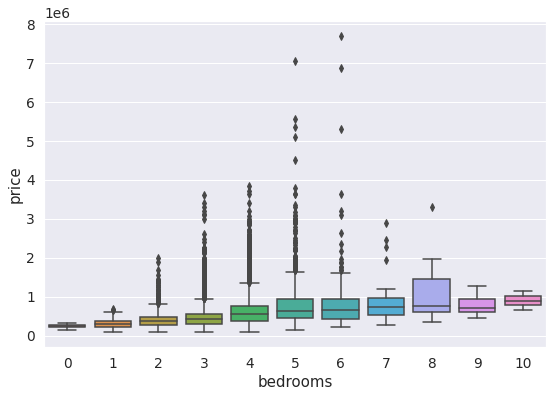

In [88]:
data = pd.concat([train['bedrooms'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fit = sns.boxplot(x='bedrooms', y = 'price', data=data)

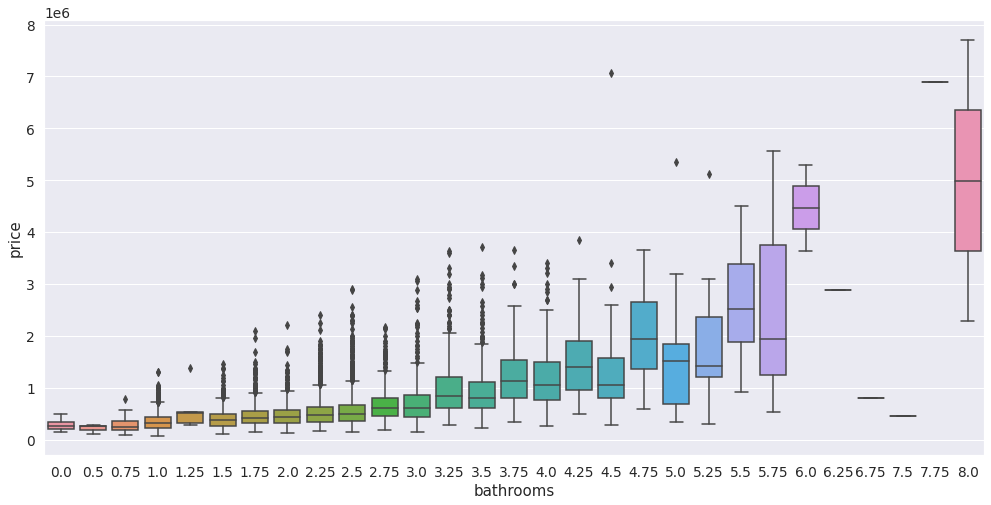

In [89]:
data = pd.concat([train['bathrooms'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(15, 8))
fit = sns.boxplot(x='bathrooms', y = 'price', data=data)

이들은 전반적으로 이상치들이 높은 비중을 차지하고 있습니다.  
이는 집 값이 낮은 지역과 높은 지역의 편차로 인해 생긴다고 추측해볼 수 있습니다.  
또힌 bathrooms에서 5를 넘어가는 box plot은 몸통이 어느 정도 길다는 것을 발견할 수 있습니다. 이것을 감안하더라도 6.75, 그리고 7.5의 가격을 생각해 본다면 이상치가 아닐까 의심이 됩니다. 추후에 이를 살펴보겠습니다.

> 1.4 lat(위도), long(경도)

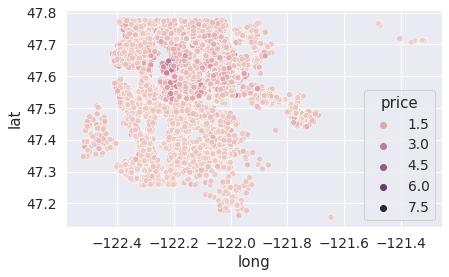

In [90]:
sns.scatterplot('long', 'lat', hue='price', data=train, sizes=(40, 80))

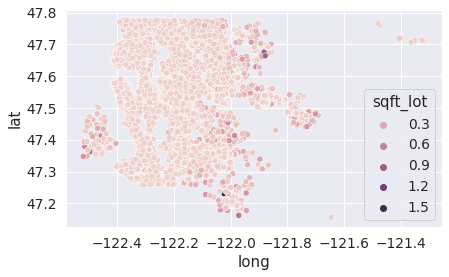

In [91]:
sns.scatterplot('long', 'lat', hue='sqft_lot', data=train, sizes=(40, 80))

위도(lat)와 경도(long), 그리고 집값을 기준으로 그래프를 그려보면 위치에 따라 편차가 존재하는 것을 발견할 수 있습니다.  
위도와 경도를 기준으로 가격을 살펴 본다면 편차가 심하게 나타나는 현상들을 설명할 수 있을 것입니다.  
sqft_lot의 경우 그래프를 통해 price와의 관계를 규명할 수 없었습니다. 따라서 위도, 경도, 가격을 함께 고려해 봤지만 별 다른 상관관계를 찾지 못했습니다.

##  Part2: Feature Engineering and Data Cleaning

> 2.1 grade  
지역에 따라서 집 값에 편차가 있다는 사실을 감안하더라도 이상치로 의심되는 요소들은 존재합니다.

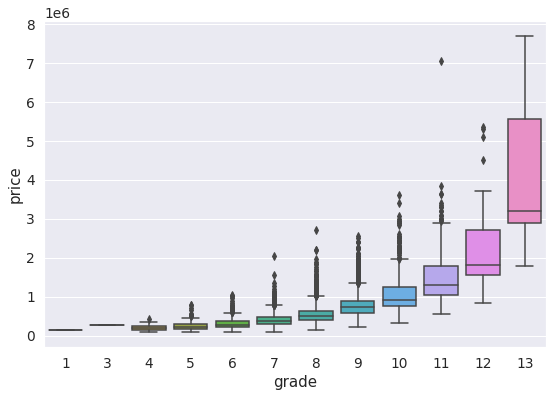

In [92]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fit = sns.boxplot(x='grade', y = 'price', data=data)

In [93]:
train.loc[(train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,262000.0,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,201411,280000.0,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [94]:
train.loc[(train['grade'] == 4)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
246,246,201406,299000.0,1,0.75,560,12120,1.0,0,0,3,4,560,0,1967,0,98014,47.6750,-121.854,1300,19207
339,339,201405,80000.0,1,0.75,430,5050,1.0,0,0,2,4,430,0,1912,0,98014,47.6499,-121.909,1200,7500
774,774,201411,140000.0,1,1.00,730,6890,1.0,0,0,4,4,730,0,1926,0,98055,47.4670,-122.215,1790,7969
2753,2753,201504,248000.0,2,1.00,770,8600,1.0,0,0,4,4,770,0,1914,0,98027,47.5325,-122.031,1420,6960
3698,3698,201410,352000.0,2,0.75,760,33801,1.0,0,0,4,4,760,0,1931,0,98059,47.4703,-122.076,1100,39504
4574,4574,201504,217000.0,2,1.00,730,2400,1.0,0,1,3,4,730,0,1934,0,98198,47.3500,-122.322,1220,4382
5607,5607,201406,120000.0,2,1.00,990,39964,1.0,0,0,2,4,990,0,1945,0,98042,47.3577,-122.085,1560,8990
6041,6041,201406,355000.0,1,1.75,750,20339,1.0,0,0,4,4,550,200,1946,0,98059,47.4756,-122.090,2020,23958
6042,6042,201501,325000.0,1,0.75,410,8636,1.0,0,0,2,4,410,0,1953,0,98146,47.5077,-122.357,1190,8636
6835,6835,201505,435000.0,2,0.75,750,16321,1.0,0,1,3,4,750,0,1936,0,98034,47.6985,-122.229,3020,10625


grade3, 4를 받은 집들의 위도, 경도를 비교해 보면 위치상의 차이가 있는 것을 확인할 수 있습니다. 앞에서는 grade3이 이상치가 아닐까 의심했지만 집값이 비싼 지역임을 고려한다면 그렇지 않을 수 있으므로 grade3은 삭제하지 않겠습니다.

In [95]:
train.loc[(train['grade'] == 11) & (train['price']>6000000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,7062500.0,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


grade 11의 이상치는 제거합니다.

In [96]:
train = train.loc[train['id']!=2775]

> 2.2 sqrt_living 

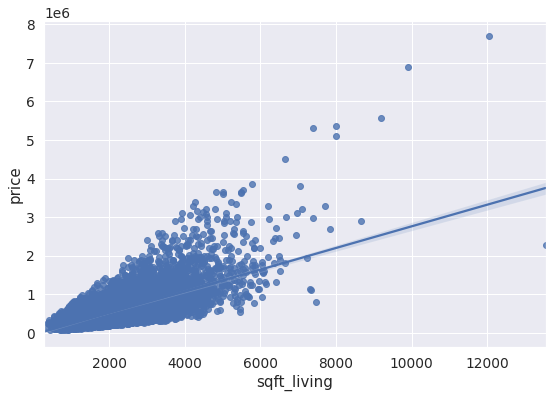

In [97]:
data = pd.concat([train['sqft_living'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

In [98]:
train.loc[(train['sqft_living']>12000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5108,5108,201410,7700000.0,6,8.0,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
8912,8912,201405,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [99]:
train.loc[(train['grade'] == 11) & (train['price']>6000000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [100]:
train = train.loc[train['id']!=8912] # sqft_living>12000 요소를 제거합니다.

> 2.3 bedrooms 

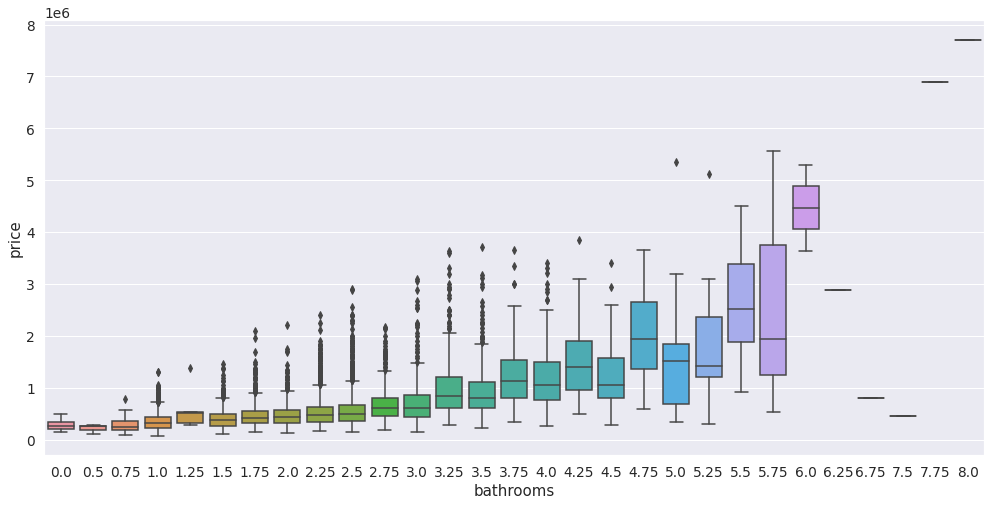

In [101]:
data = pd.concat([train['bathrooms'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(15, 8))
fit = sns.boxplot(x='bathrooms', y = 'price', data=data)

bathrooms 6.75, 7.5는 이상치로 판단하여 제거하겠습니다.

In [102]:
train.loc[(train['bathrooms']==6.75)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2859,2859,201410,800000.0,7,6.75,7480,41664,2.0,0,2,3,11,5080,2400,1953,0,98166,47.4643,-122.368,2810,33190


In [103]:
train.loc[(train['bathrooms']==7.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5990,5990,201408,450000.0,9,7.5,4050,6504,2.0,0,0,3,7,4050,0,1996,0,98144,47.5923,-122.301,1448,3866


In [104]:
train = train.loc[(train['bathrooms']!=6.75)]

In [105]:
train = train.loc[(train['bathrooms']!=7.5)]

##  Part3: Create New Variable

정규화
* 분포가 한쪽으로 기울어져 있다면(skew) 결과를 왜곡시킬 수 있습니다. 따라서 skew된 feature의 경우 log 함수에 대입하여 분포를 고르게 만들어줍니다.

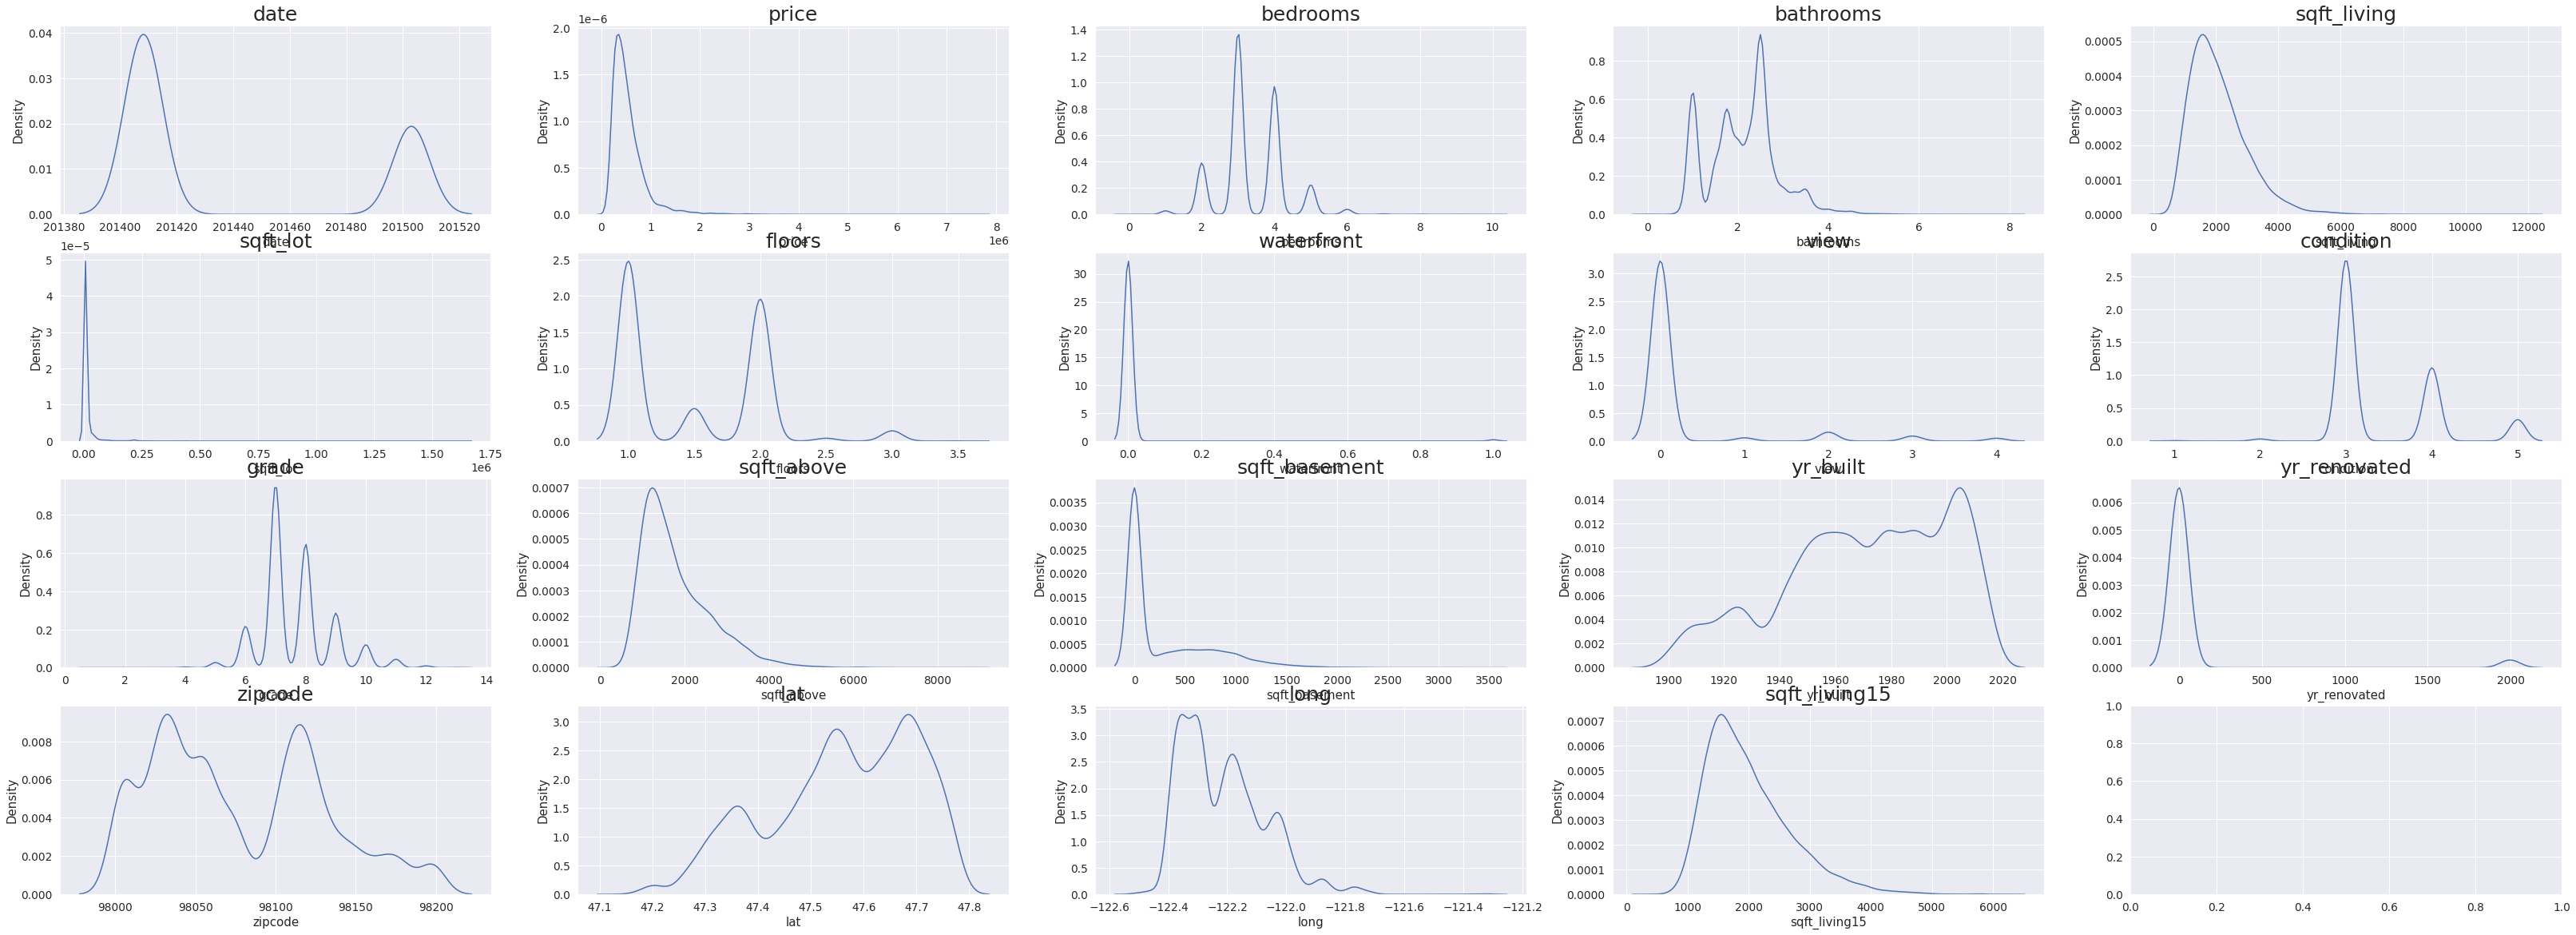

In [106]:
fig, ax = plt.subplots(4, 5, figsize=(50, 20))

count = 1
columns = train.columns

for row in range(4):
  for col in range(5):
    sns.kdeplot(train[columns[count]], ax = ax[row][col])
    ax[row][col].set_title(columns[count], fontsize=25)
    count += 1
    if count ==20:
      break

In [107]:
skew_list = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15', 'sqft_lot15' ]

for c in skew_list:
  train[c] = np.log1p(train[c].values)

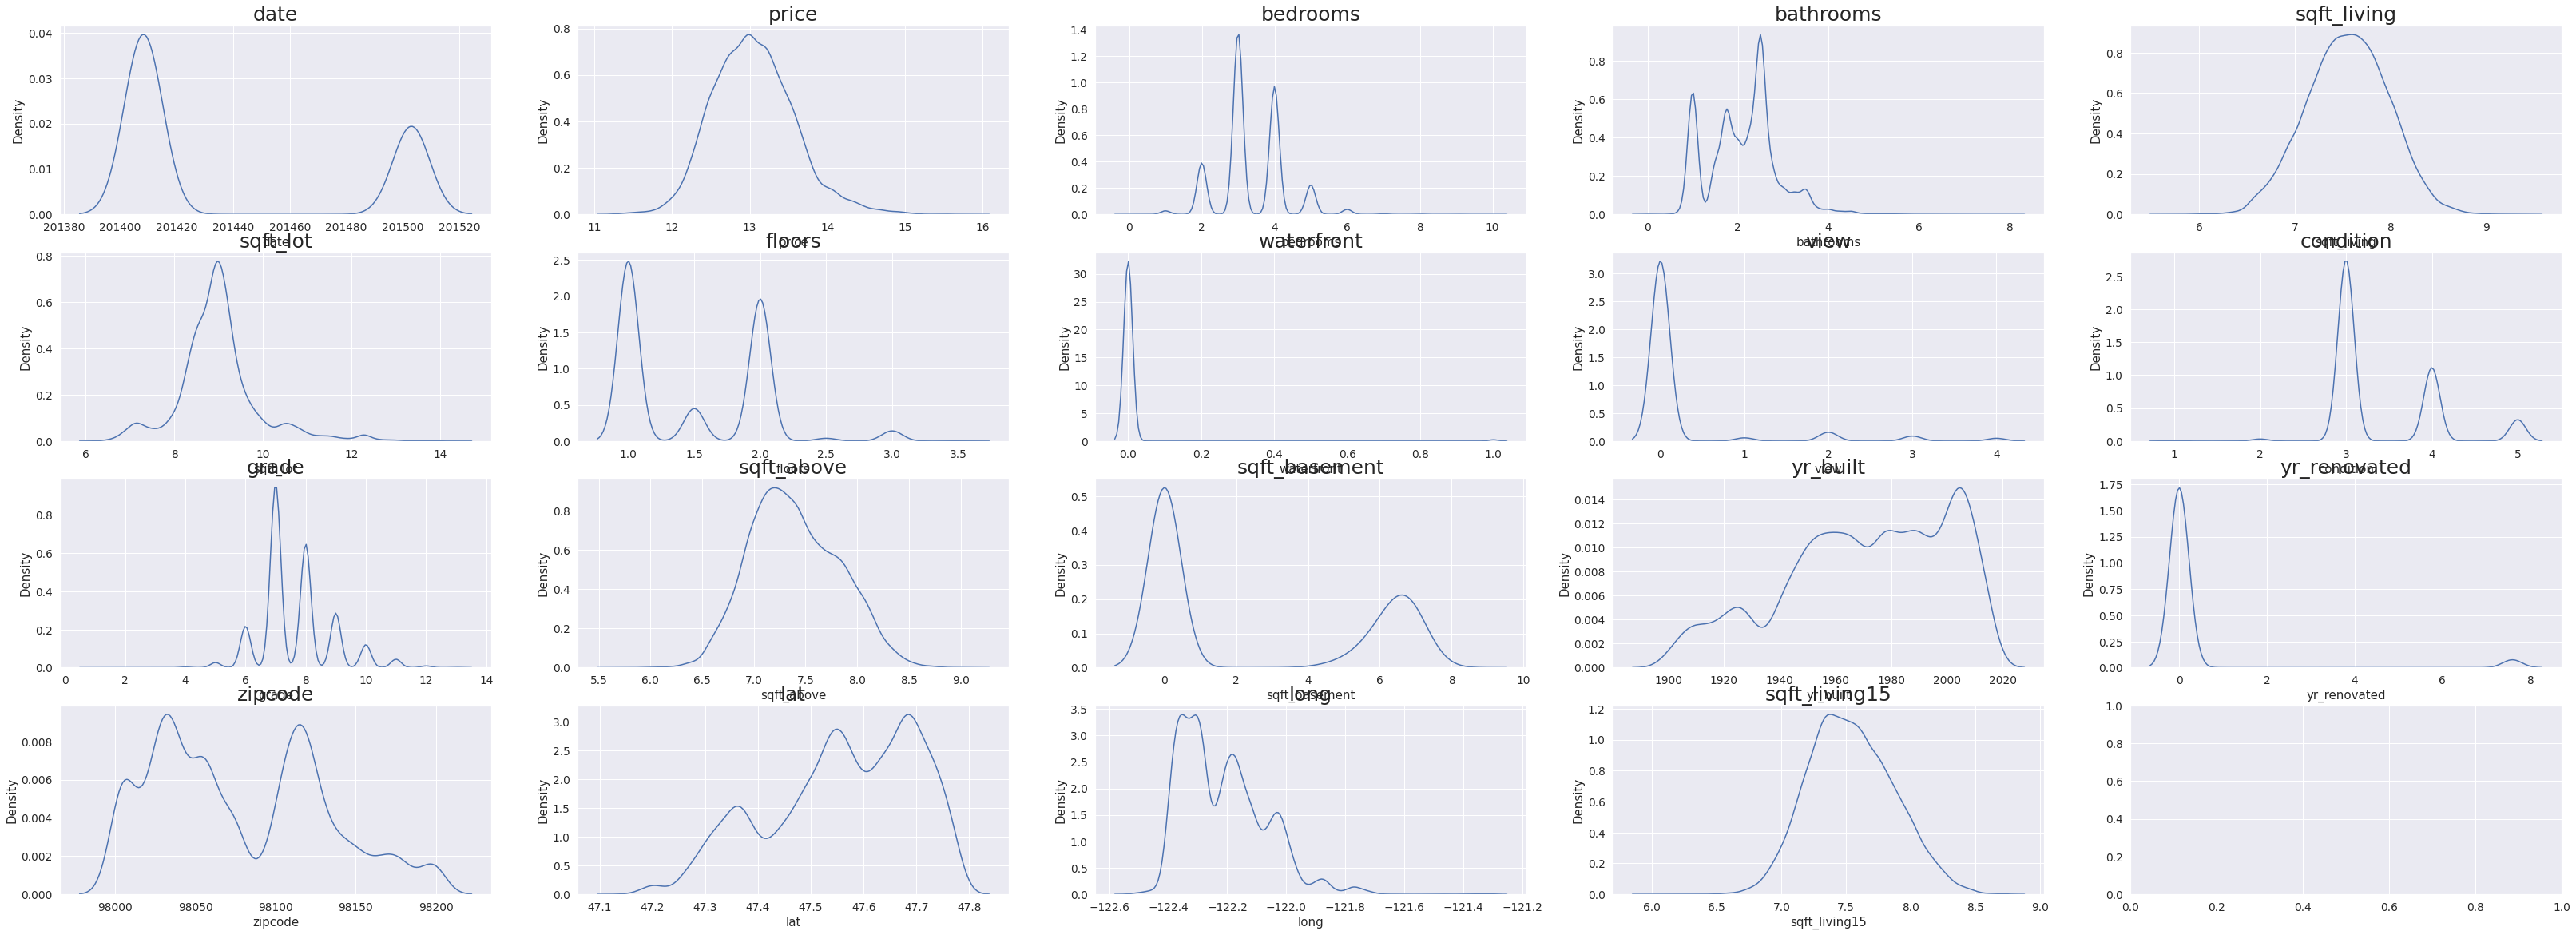

In [108]:
fig, ax = plt.subplots(4, 5, figsize=(50, 20))

count = 1
columns = train.columns

for row in range(4):
  for col in range(5):
    sns.kdeplot(train[columns[count]], ax = ax[row][col])
    ax[row][col].set_title(columns[count], fontsize=25)
    count += 1
    if count ==20:
      break

In [109]:
skew_list = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15', 'sqft_lot15' ]

for c in skew_list:
  test[c] = np.log1p(test[c].values)

변수 생성
* 연관성이 있는 feature은 묶어줍니다.
* 범주화가 필요하다고 판단되는 feature은 범주화, 원핫인코딩을 진행합니다.

In [110]:
for df in [train, test]:

  # 방의 전체 갯수
  df['total_rooms'] = df['bedrooms'] + df['bathrooms']

  # 거실의 비율
  df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']

  # 면적 대비 거실의 비율
  df['sqft_ratio'] = df['sqft_living'] / df['sqft_total_size']
  # 재건축 여부
  df['is_renovated'] = df['yr_renovated'] - df['yr_built']
  df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

위도, 경도 기준으로 범주화, 원핫인코딩을 진행합니다.

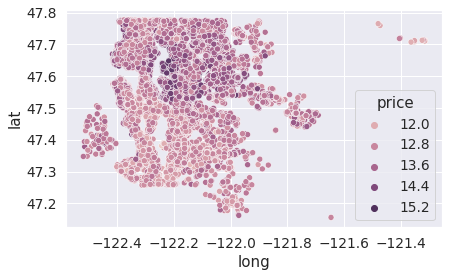

In [111]:
sns.scatterplot('long', 'lat', hue='price', data=train, sizes=(40, 80))

In [112]:
for df in [train, test]:
  # 경도(long) 범주화

  df['long_band']=0
  df.loc[df['long']< -122.4, 'long_band']=0
  df.loc[(df['long'] >= -122.4)&(df['long']<-122.2), 'long_band']=1
  df.loc[(df['long']>= -122.2)&(df['long']<-122.0), 'long_band']=2
  df.loc[(df['long']>=-122.0)&(df['long']<-121.8), 'long_band']=3
  df.loc[(df['long']>=-121.8)&(df['long']<-121.6), 'long_band']=4
  df.loc[(df['long']>=-121.6)&(df['long']<-121.4), 'long_band']=5
  df.loc[(df['long']>=-121.4, 'long_band')]=6

In [113]:
for df in [train, test]:
  # 위도(lat)) 범주화

  df['lat_band']=0
  df.loc[df['lat']< 47.2, 'lat_band']=0
  df.loc[(df['lat'] >= 47.2)&(df['lat']<47.3), 'lat_band']=1
  df.loc[(df['lat'] >= 47.3)&(df['lat']<47.4), 'lat_band']=2
  df.loc[(df['lat'] >= 47.4)&(df['lat']<47.5), 'lat_band']=3
  df.loc[(df['lat'] >= 47.5)&(df['lat']<47.6), 'lat_band']=4
  df.loc[(df['lat'] >= 47.6)&(df['lat']<47.7), 'lat_band']=5
  df.loc[(df['lat'] >= 47.7)&(df['lat']<47.8), 'lat_band']=6
  df.loc[df['lat'] >= 47.8, 'lat_band']=7

In [114]:
pd.get_dummies(train, columns=['lat_band', 'long_band']) #원-핫 인코딩

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_total_size,sqft_ratio,is_renovated,lat_band_0,lat_band_1,lat_band_2,lat_band_3,lat_band_4,lat_band_5,lat_band_6,long_band_0,long_band_1,long_band_2,long_band_3,long_band_4,long_band_5,long_band_6
0,0,201410,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0.0,98178,47.5112,-122.257,7.201171,8.639588,4.00,7.074117,1.000000,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,1,201502,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0.0,98028,47.7379,-122.233,7.908755,8.995041,3.00,6.647688,1.000000,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,2,201502,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0.0,98074,47.6168,-122.045,7.496097,8.923191,5.00,7.427144,1.000000,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,3,201406,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0.0,98003,47.3097,-122.327,7.713785,8.827615,5.25,7.447751,1.000000,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,4,201501,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0.0,98198,47.4095,-122.315,7.409136,9.181118,4.50,6.966967,1.000000,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,13.322338,4,2.50,7.832411,8.703507,2.0,0,0,3,9,7.832411,0.000000,2014,0.0,98056,47.5137,-122.167,7.832411,8.703507,6.50,7.832411,1.000000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
15031,15031,201503,13.822984,4,3.50,8.163656,8.881975,2.0,0,0,3,9,7.863651,6.814543,2009,0.0,98136,47.5537,-122.398,7.626083,8.732466,7.50,14.678194,0.556176,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
15032,15032,201405,12.793862,3,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,0.0,98103,47.6993,-122.346,7.333676,7.319865,5.50,7.333676,1.000000,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
15033,15033,201502,12.899222,4,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,0.0,98146,47.5107,-122.362,7.512618,8.881975,6.50,7.745436,1.000000,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [115]:
pd.get_dummies(test, columns=['lat_band', 'long_band']) #원-핫 인코딩

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_total_size,sqft_ratio,is_renovated,lat_band_0,lat_band_1,lat_band_2,lat_band_3,lat_band_4,lat_band_5,lat_band_6,long_band_0,long_band_1,long_band_2,long_band_3,long_band_4,long_band_5,long_band_6
0,15035,201412,3,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,7.596894,98125,47.7210,-122.319,7.433075,8.941153,5.25,13.676905,0.574110,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,15036,201412,4,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0.000000,98136,47.5208,-122.393,7.215975,8.517393,7.00,13.772040,0.550478,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,15037,201405,4,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0.000000,98053,47.6561,-122.005,8.468213,11.532051,8.50,15.600098,0.551153,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,15038,201504,3,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0.000000,98146,47.5123,-122.337,7.484930,9.001346,4.00,13.551911,0.552315,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,15039,201503,3,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0.000000,98038,47.3684,-122.031,7.779467,8.932080,5.50,7.544861,1.000000,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,201406,3,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0.000000,98010,47.3095,-122.002,7.186144,9.332912,4.75,7.313887,1.000000,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
6464,21499,201501,3,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0.000000,98144,47.5699,-122.288,7.244942,7.115582,5.00,7.307202,1.000000,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
6465,21500,201502,3,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0.000000,98116,47.5773,-122.409,7.193686,7.143618,5.50,11.949314,0.600750,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
6466,21501,201406,2,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0.000000,98144,47.5944,-122.299,6.928538,7.604894,2.75,6.928538,1.000000,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0


## Part4: Predictive Modeling

In [116]:
sub = test

In [117]:
x = train.astype('float32')

In [118]:
y = x['price']
del x['price']

In [119]:
y = y.astype('int')
y

0        12
1        12
2        13
3        12
4        12
         ..
15030    13
15031    13
15032    12
15033    12
15034    12
Name: price, Length: 15031, dtype: int64

In [120]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [122]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))

In [123]:
get_cv_score(models)

Model GradientBoosting CV score : 0.7220
[04:35:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:35:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model XGBoost CV score : 0.7213
Model LightGBM CV score : 0.7497


In [124]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [125]:
len(x.columns)

26

In [126]:
len(sub.columns)

26

In [127]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[04:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([12.73887024, 12.34955464, 13.54187626, ..., 12.49032091,
       12.0574911 , 12.37233633])

In [129]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration6/house_price_prediction'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [136]:
result = pd.DataFrame({
    'id' : sub['id'], 
    'price' : y_pred
})

result.head()

,id,price
0,15035,12.738870
1,15036,12.349555
2,15037,13.541876
3,15038,12.033836
4,15039,12.032547


In [138]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/content/drive/MyDrive/Colab Notebooks/Aiffel/Exploration/Exploration6/house_price_prediction/submission.csv
